In [1]:
%matplotlib inline
import glob
import os
import matplotlib.pyplot as plt

import artm

# Адрес, по которому находятся данные
BATCH_ADRESS = 'batches_news'

# Вывод версии BigARTM
print(artm.version())

0.10.0


In [2]:
# Установка адреса, по которому находятся данные
batch_vectorizer = artm.BatchVectorizer(
    data_path=BATCH_ADRESS, data_format='batches'
)

In [8]:
# Пересоздание словаря для модели и сохранение его в файл

# Устанавливается название словаря для модели
dictionary_address = BATCH_ADRESS + '/dictionary.dict'

# Инициализация словоря для модели
dictionary = artm.Dictionary()

# Удаление словаря, оставшегося после предыдущих запусков
if os.path.isfile(dictionary_address):
    os.remove(dictionary_address)
    
# Сохранение словаря в файл
dictionary.gather(data_path=batch_vectorizer.data_path)
dictionary.save(dictionary_path=dictionary_address)

# Загрузка словаря из файла
dictionary.load(dictionary_path=dictionary_address)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре"
)


# Фильтрация

# Убираются редкие слова по всей коллекции
# Слово встречается во всей коллекции больше чем n раз
dictionary.filter(min_tf=10)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_tf", 
)

# Убираются частые слова по всей коллекции
# Слово встречается во всей коллекции меньше чем n раз
#dictionary.filter(max_tf=2000)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_tf", 
)

# Убираются слова, которые попадаются меньше чем в n процентов документов
dictionary.filter(min_df_rate=0.0001)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по min_df_rate", 
)

# Убираются слова, которые попадаются больше чем в n процентов документов
dictionary.filter(max_df_rate=0.6)
print(
    '{:>7}'.format(dictionary.__dict__['_master'].get_info().dictionary[0].num_entries),
    "- количество слов в словаре после фильтрации по max_df_rate", 
)

  75725 - количество слов в словаре
  19855 - количество слов в словаре после фильтрации по min_tf
  19855 - количество слов в словаре после фильтрации по max_tf
  19497 - количество слов в словаре после фильтрации по min_df_rate
  19493 - количество слов в словаре после фильтрации по max_df_rate


In [9]:
def new_default_model(topic_count, dictionary):
    
    # Создание модели
    model_artm = artm.ARTM(
        # Названия тем
        topic_names=['topic_{0:0>3}'.format(i) for i in range(topic_count)], 
        # Разрешается хранить матрицу theta в памяти
        cache_theta=True,
        # Фиксация seed для воспроизвдимости результатов
        seed=-1,
        # Настройка - сколько раз обрабатывать каждый документ
        num_document_passes=1,
        # Модальности
        #class_ids={'text': 1.0},
    )

    # Инициализация модели
    model_artm.initialize(dictionary=dictionary)

    # Установка отслеживаемых параметров
    # Перплексия (чем она меньше тем лучше)
    model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore'))
    # Разреженность матрицы Phi (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore'))
    # Разреженность матрицы Theta (доля почти нулевых значений)
    model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
    # Анализ самых используемых слов по темам
    model_artm.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=10))
    # Анализ ядра тем на контраст и чистоту
    model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore'))
    #model_artm.scores.add(artm.TopicKernelScore(name='TopicKernelScore', probability_mass_threshold=0.3))
    
    return model_artm

In [10]:
def model_print_results(model_artm):
    
    # Графики
    
    fig = plt.figure(figsize=(15, 20))

    ax = plt.subplot2grid((4,3), (0,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["PerplexityScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('PerplexityScore')
    ax.grid(True)

    ax = plt.subplot2grid((4,3), (0,1), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityPhiScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityPhiScore')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (0,2), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["SparsityThetaScore"].value, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('SparsityThetaScore')
    ax.grid(True)
    ax.set_ylim([0,1])


    ax = plt.subplot2grid((4,3), (1,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker["TopicKernelScore"].average_contrast, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_contrast')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (1,1), colspan = 2, rowspan = 1,  fig=fig)
    my_contrast_dictionary = model_artm.score_tracker['TopicKernelScore'].last_contrast
    ax.bar(my_contrast_dictionary.keys(), my_contrast_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (2,0), colspan = 1, rowspan = 1,  fig=fig)
    ax.plot(model_artm.score_tracker['TopicKernelScore'].average_purity, color='tab:blue')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_purity')
    ax.grid(True)
    ax.set_ylim([0,1])

    ax = plt.subplot2grid((4,3), (2,1), colspan = 2, rowspan = 1,  fig=fig)
    my_purity_dictionary = model_artm.score_tracker['TopicKernelScore'].last_purity
    ax.bar(my_purity_dictionary.keys(), my_purity_dictionary.values(), 0.5, color='tab:blue')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)


    ax = plt.subplot2grid((4,3), (3,0), colspan = 1, rowspan = 1,  fig=fig)
    my_average_size = model_artm.score_tracker['TopicKernelScore'].average_size
    ax.plot(my_average_size, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(len(my_average_size))], color='tab:orange')
    ax.set_xlabel('Iterations count')
    ax.set_ylabel('TopicKernelScore_average_size')
    ax.grid(True)
    ax.set_ylim([0,ax.get_ylim()[1]])

    ax = plt.subplot2grid((4,3), (3,1), colspan = 2, rowspan = 1,  fig=fig)
    my_size_dictionary = model_artm.score_tracker['TopicKernelScore'].last_size
    ax.bar(my_size_dictionary.keys(), my_size_dictionary.values(), 0.5, color='tab:blue')
    ax.plot([model_artm.phi_.shape[0]/model_artm.num_topics for i in range(model_artm.num_topics)], color='tab:orange')
    ax.set_xlabel('//')
    ax.set_ylabel('//')
    ax.grid(True)
    ax.tick_params(axis='x', rotation=90)

    plt.show()
    
    
    # Конечные значения
    
    print("PerplexityScore:", model_artm.score_tracker["PerplexityScore"].last_value)
    print("SparsityPhiScore:", model_artm.score_tracker["SparsityPhiScore"].last_value)
    print("SparsityThetaScore:", model_artm.score_tracker["SparsityThetaScore"].last_value)
    print()
    print("TopicKernelScore_average_contrast:", model_artm.score_tracker["TopicKernelScore"].last_average_contrast)
    print("TopicKernelScore_average_purity:", model_artm.score_tracker['TopicKernelScore'].last_average_purity)
    print("TopicKernelScore_average_size:", model_artm.score_tracker['TopicKernelScore'].last_average_size)
    
    print()
    
    
    # Главные слова в темах
    
    print("TopTokensScore:")
    topic_list = list(model_artm.score_tracker['TopTokensScore'].last_tokens.keys())
    for topic_name in topic_list:
        print(topic_name + ': ', end='')
        for token_name in model_artm.score_tracker['TopTokensScore'].last_tokens[topic_name]:
            print(token_name, end=' ')
        print()

In [11]:
params = {
    'topic_count': 15,
    'num_collection_passes': 40,
    'SparsePhi': {
        'name': 'SparsePhi',
        'tau': -5,
    },
    'SparseTheta': {
        'name': 'SparseTheta',
        'tau': -3,
    },
    'DecorrelatorPhi': {
        'name': 'DecorrelatorPhi',
        'tau': 25_000_000,
    }
}

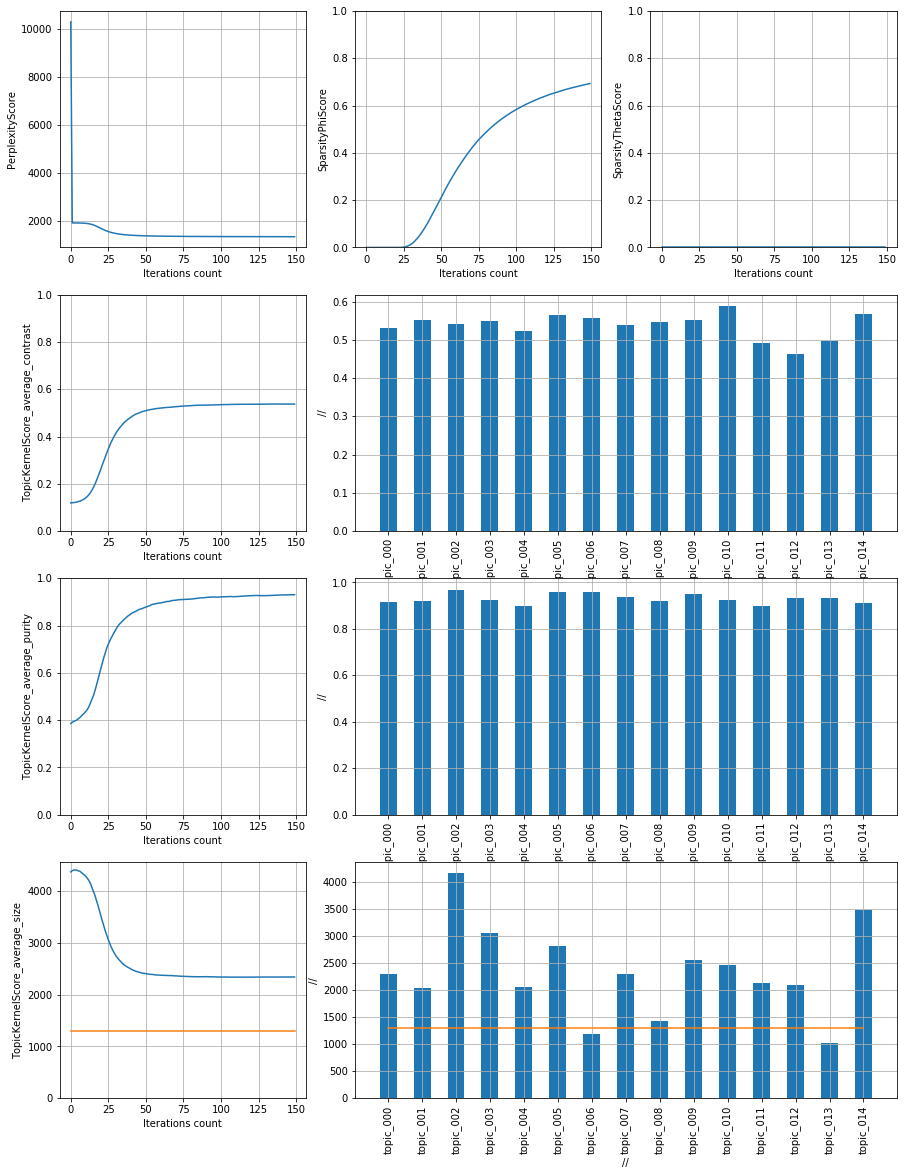

PerplexityScore: 1355.754638671875
SparsityPhiScore: 0.693496823310852
SparsityThetaScore: 0.0

TopicKernelScore_average_contrast: 0.5372451543807983
TopicKernelScore_average_purity: 0.9306766986846924
TopicKernelScore_average_size: 2339.466552734375

TopTokensScore:
topic_000: колония право осужденный жалоба решение заключенный человек нарушение сизо фсин 
topic_001: задерживать полиция полицейский акция активист москва задержание человек сотрудник задержанный 
topic_002: весь человек такой если чтобы только свой этот себя когда 
topic_003: россия российский 2015 закон президент 2016 новый владимир путин принимать 
topic_004: навальный информация журналист алексей сайт решение представитель опубликовывать газета свой 
topic_005: мужчина летний ребенок женщина житель полицейский область полиция смерть убийство 
topic_006: статья часть следствие признавать обвиняемый версия обвинение приговор свобода приговаривать 
topic_007: человек данные источник ссылка агентство место москва один ра

In [12]:
# Создание базовой пустой модели
model_artm = new_default_model(params['topic_count'], dictionary)

# Модель 0_0
# Запуск регуляризатора SparsePhi

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=150)

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_0")
model_artm_0_0 = model_artm.clone()

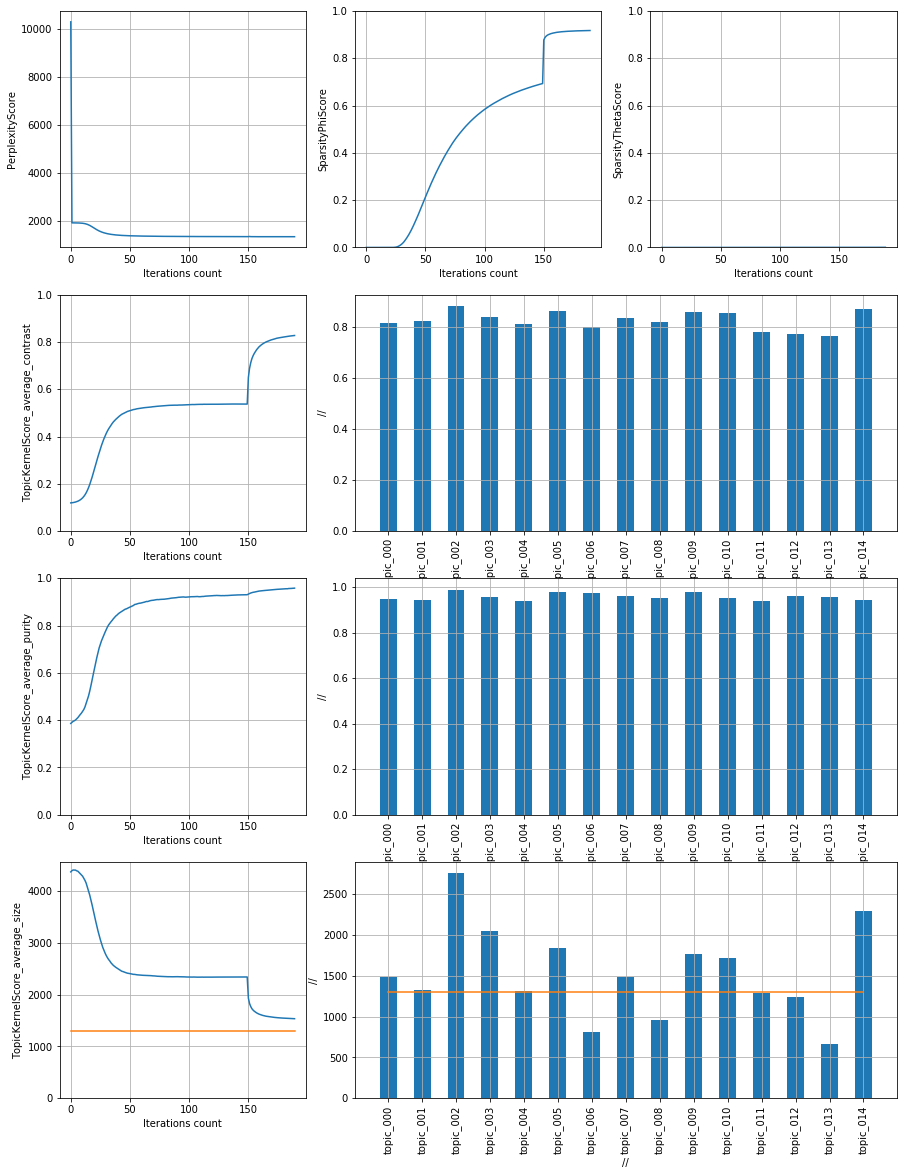

PerplexityScore: 1352.9095458984375
SparsityPhiScore: 0.9178474545478821
SparsityThetaScore: 0.0005747614777646959

TopicKernelScore_average_contrast: 0.8274555206298828
TopicKernelScore_average_purity: 0.9584800004959106
TopicKernelScore_average_size: 1534.933349609375

TopTokensScore:
topic_000: колония право осужденный решение жалоба заключенный нарушение человек сизо фсин 
topic_001: задерживать полиция полицейский акция активист москва задержание человек задержанный сотрудник 
topic_002: весь человек такой если этот только чтобы свой мочь себя 
topic_003: россия российский закон президент 2016 2015 принимать число владимир путин 
topic_004: навальный информация журналист сайт алексей представитель газета опубликовывать решение свой 
topic_005: мужчина летний ребенок женщина житель полицейский область полиция смерть убийство 
topic_006: статья часть следствие признавать обвиняемый версия обвинение приговор арест свобода 
topic_007: человек данные источник ссылка агентство москва ме

In [13]:
# Модель 0_1
# Запуск регуляризатора SparsePhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора, если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_1")
model_artm_0_1 = model_artm.clone()

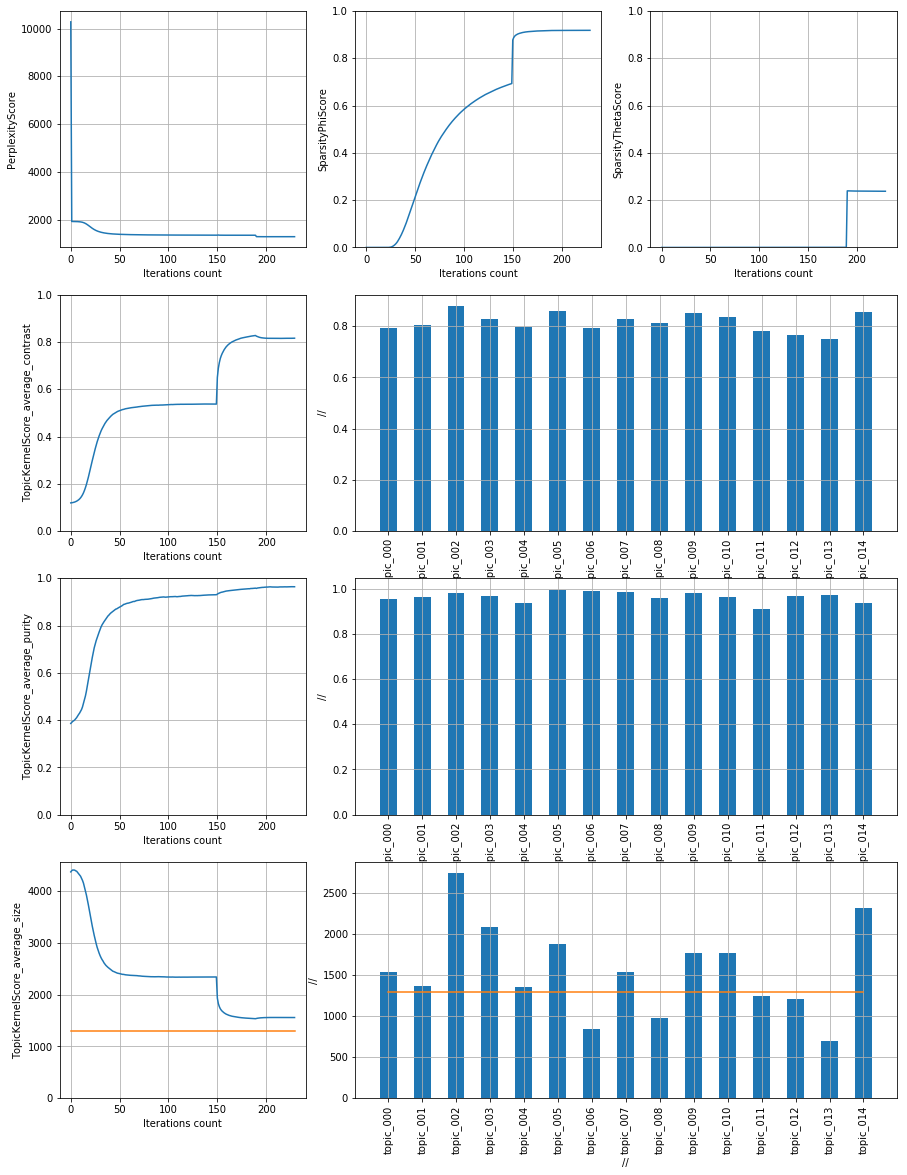

PerplexityScore: 1292.2698974609375
SparsityPhiScore: 0.9186443090438843
SparsityThetaScore: 0.23777569830417633

TopicKernelScore_average_contrast: 0.8160099387168884
TopicKernelScore_average_purity: 0.9644247889518738
TopicKernelScore_average_size: 1557.5333251953125

TopTokensScore:
topic_000: колония право осужденный решение жалоба человек заключенный нарушение фсин сизо 
topic_001: задерживать полиция полицейский акция активист москва задержание человек сотрудник задержанный 
topic_002: весь такой человек мочь если этот только чтобы свой когда 
topic_003: россия российский закон президент мочь 2016 путин владимир 2015 такой 
topic_004: навальный информация журналист алексей свой газета сайт опубликовывать решение представитель 
topic_005: мужчина летний ребенок полицейский полиция женщина область после житель убийство 
topic_006: статья часть следствие признавать обвиняемый обвинение приговор приговаривать свобода арест 
topic_007: человек данные источник агентство ссылка москва м

In [14]:
# Модель 0_2
# Запуск регуляризатора SparseTheta к уже включенному SparsePhi

# Загрузка модели
model_artm = model_artm_0_1.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_2")
model_artm_0_2 = model_artm.clone()

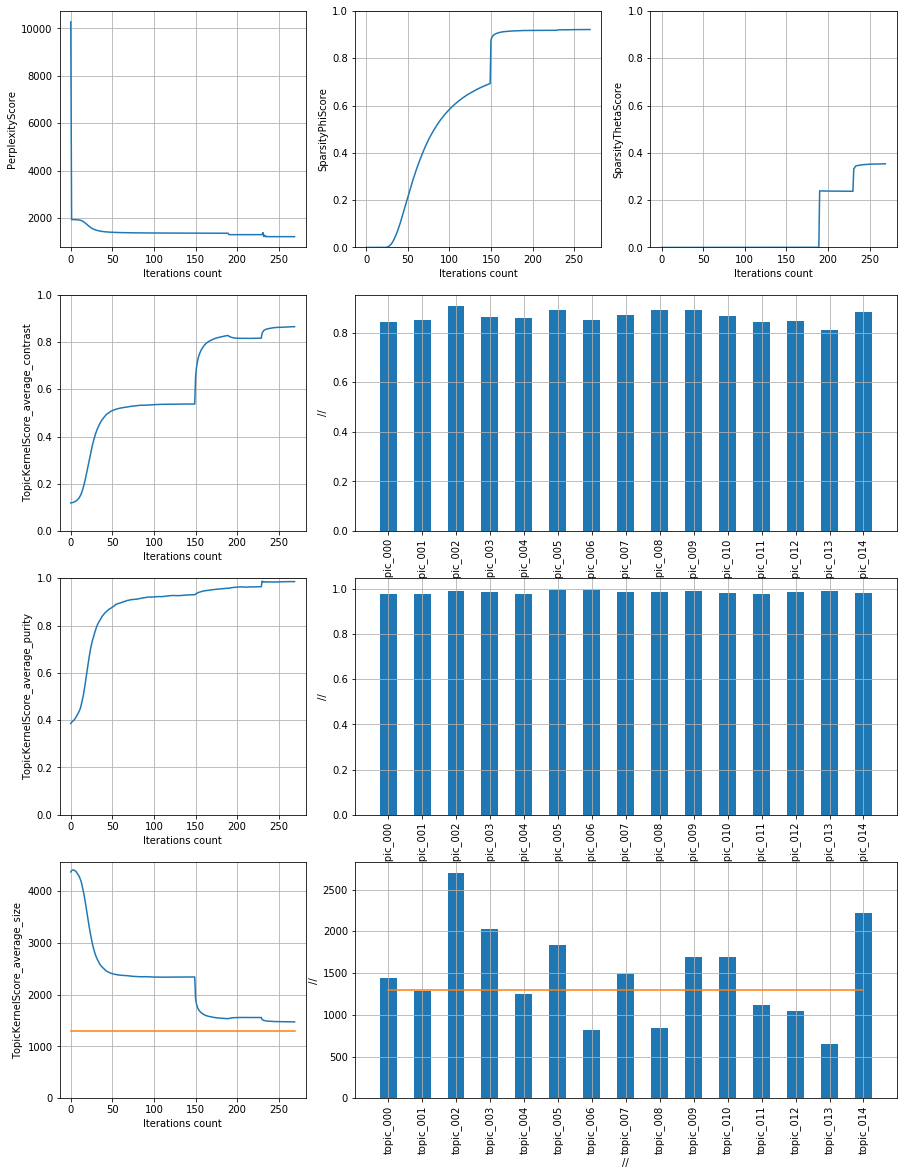

PerplexityScore: 1208.1539306640625
SparsityPhiScore: 0.9220643043518066
SparsityThetaScore: 0.353840708732605

TopicKernelScore_average_contrast: 0.8647834658622742
TopicKernelScore_average_purity: 0.9861219525337219
TopicKernelScore_average_size: 1473.86669921875

TopTokensScore:
topic_000: колония право нарушение осужденный сергей жалоба сизо заключенный представлять судебный 
topic_001: задерживать акция активист задержание приходить март протокол участник задержанный 2017 
topic_002: если себя сейчас работать много хотеть идти понимать сделать потому 
topic_003: российский власть принимать должный закон владимир президент случай число предлагать 
topic_004: навальный информация алексей журналист написать газета опубликовывать депутат мнение указывать 
topic_005: мужчина летний ребенок житель женщина город находить местный больница смерть 
topic_006: статья часть следствие признавать обвинение версия свобода арест 2016 обвиняемый 
topic_007: данные место источник издание происходит

In [15]:
# Модель 0_3
# Запуск регуляризатора DecorrelatorPhi к уже включенным SparsePhi, SparseTheta

# Загрузка модели
model_artm = model_artm_0_2.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_0_3")
model_artm_0_3 = model_artm.clone()

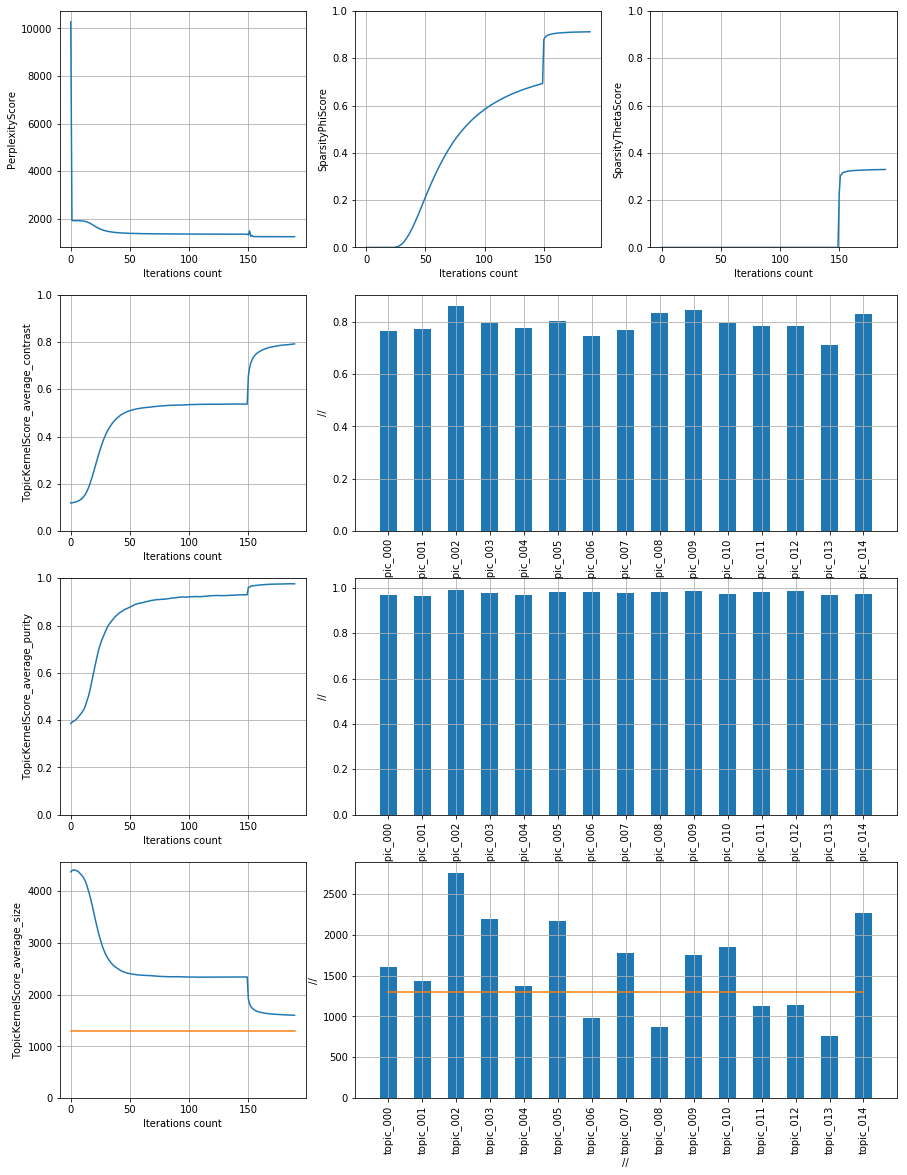

PerplexityScore: 1250.5999755859375
SparsityPhiScore: 0.9124437570571899
SparsityThetaScore: 0.3297998309135437

TopicKernelScore_average_contrast: 0.7919244170188904
TopicKernelScore_average_purity: 0.9767962098121643
TopicKernelScore_average_size: 1601.4666748046875

TopTokensScore:
topic_000: россия колония право нарушение сторона осужденный жалоба сизо заключенный наказание 
topic_001: задерживать полиция акция активист задержание протокол участник март задержанный июнь 
topic_002: чтобы только если сейчас работать себя хотеть понимать сделать потому 
topic_003: российский 2016 власть принимать закон президент число случай владимир путин 
topic_004: навальный информация представитель сайт журналист алексей написать газета опубликовывать депутат 
topic_005: мужчина летний ребенок житель женщина больница местный смерть квартира помощь 
topic_006: статья часть следствие признавать обвинение давать версия преступление свобода арест 
topic_007: данные место источник издание происходить 

In [16]:
# Альтернативная модель 1_0
# Запуск одновременно 3 регуляризаторов SparsePhi, SparseTheta, DecorrelatorPhi

# Загрузка модели
model_artm = model_artm_0_0.clone()

# Регуляризатор SparsePhi
# Создание регуляризатора если он уже не создан
if params['SparsePhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name=params['SparsePhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparsePhi']['name']].tau = params['SparsePhi']['tau']

# Регуляризатор SparseTheta
# Создание регуляризатора если он уже не создан
if params['SparseTheta']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.SmoothSparseThetaRegularizer(name=params['SparseTheta']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['SparseTheta']['name']].tau = params['SparseTheta']['tau']

# Регуляризатор DecorrelatorPhi
# Создание регуляризатора если он уже не создан
if params['DecorrelatorPhi']['name'] not in list(model_artm.regularizers.data):
    model_artm.regularizers.add(artm.DecorrelatorPhiRegularizer(name=params['DecorrelatorPhi']['name']))
# Настройка регуляризатора
model_artm.regularizers[params['DecorrelatorPhi']['name']].tau = params['DecorrelatorPhi']['tau']

# Обучение модели
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=params['num_collection_passes'])

# Вывод метрик модели
model_print_results(model_artm)

# Сохранение модели
model_artm.save("news_model_1_0")
model_artm_1_0 = model_artm.clone()

In [17]:
phi = model_artm.phi_
phi

,topic_000,topic_001,topic_002,topic_003,topic_004,topic_005,topic_006,topic_007,topic_008,topic_009,topic_010,topic_011,topic_012,topic_013,topic_014
суоярви,0.000048,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
заваркин,0.000141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
эпплбаум,0.000000,0.000000,0.000024,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
заваркина,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
голышева,0.000000,0.000029,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
мусаевич,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000022,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
долиева,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000017,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
крамчанинов,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000057,0.000000
буховский,0.000019,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
хагдаев,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000128


In [18]:
theta = model_artm.get_theta()
theta

,9000,9001,9002,9003,9004,9005,9006,9007,9008,9009,...,14990,14991,14992,14993,14994,14995,14996,14997,14998,14999
topic_000,0.029490,0.060161,0.024819,0.144153,0.081925,0.032001,0.044853,0.040498,0.072777,0.051252,...,0.030443,0.025231,0.054303,0.039619,0.041756,0.045027,0.042669,0.031368,0.019064,0.062953
topic_001,0.043107,0.047108,0.042276,0.057413,0.299985,0.014423,0.037273,0.053665,0.038652,0.054666,...,0.062416,0.050211,0.093878,0.054094,0.161244,0.051343,0.059016,0.033293,0.034253,0.058096
topic_002,0.036899,0.034064,0.062361,0.026612,0.024460,0.105031,0.053029,0.080409,0.085665,0.047591,...,0.031151,0.042228,0.006374,0.014562,0.078147,0.019484,0.004895,0.028603,0.010204,0.050042
topic_003,0.038055,0.029718,0.046724,0.014273,0.035627,0.069909,0.031708,0.028637,0.157526,0.070629,...,0.042963,0.058319,0.013855,0.030189,0.028365,0.052565,0.017768,0.099615,0.180363,0.040044
topic_004,0.038687,0.097918,0.050483,0.030449,0.104857,0.289560,0.071523,0.022716,0.150484,0.087936,...,0.032814,0.024427,0.042797,0.019817,0.063945,0.025168,0.021345,0.066392,0.085494,0.116986
topic_005,0.091631,0.051517,0.093630,0.153149,0.056536,0.036807,0.279796,0.244879,0.007872,0.024576,...,0.104855,0.120876,0.135896,0.058931,0.049741,0.065772,0.135224,0.033866,0.018608,0.026820
topic_006,0.014006,0.167341,0.008983,0.153743,0.069321,0.020713,0.006275,0.087028,0.029363,0.105272,...,0.083538,0.031188,0.126132,0.153428,0.015043,0.102475,0.191759,0.012968,0.027420,0.192334
topic_007,0.370498,0.054959,0.296507,0.129164,0.001642,0.102797,0.081487,0.052480,0.025430,0.020972,...,0.296393,0.455564,0.233250,0.214670,0.045348,0.380036,0.209560,0.249317,0.067679,0.026513
topic_008,0.060320,0.049703,0.062665,0.104804,0.047122,0.039378,0.068045,0.059049,0.045178,0.069878,...,0.018129,0.029795,0.023354,0.056562,0.071381,0.025653,0.016827,0.055148,0.054040,0.081407
topic_009,0.090602,0.037987,0.117246,0.030094,0.034452,0.062150,0.111951,0.108002,0.034134,0.016129,...,0.058479,0.061071,0.045747,0.028346,0.164271,0.057102,0.052125,0.039660,0.041493,0.021581
